# Problem

Large corporations are trying to leverage semantic search and LLMs to explore their newsroom data with retrieval augmented generation enabled Q&A. However, newsrooms are quite large (have a lot of text).
<br><br>
Using cosine similarity with BERT embeddings is a popular method to select relevant text chunks to append to a prompt, but it's computationally expensive and wait time can deter users. The search can be sped up if only half of the embeddings need comparison, so binary classification is a fair approach for sorting newsroom data queries and is only feasible using a neural network model.
<br><br>
User questions about the Texas Instruments newsroom (where I work) fall into two categories, 'corporate' and 'product/manufacturing.' Identitfying the user question categories allow for faster response times in a larger RAG context.

# EDA

In [3]:
import pandas as pd

one_hundred_labeled_questions = pd.read_csv('Generated_Labeled_Questions.csv')
one_hundred_labeled_questions.head()

,Question,Label
0,Can you explain the announcement about TI Seni...,corporate
1,What is the corporate update regarding TI repo...,corporate
2,How does TI's new Ethernet PHYs simplify desig...,product
3,What makes TI introduces industry's first SAR ...,product
4,How does TI CEO Rich Templeton to deliver keyn...,corporate


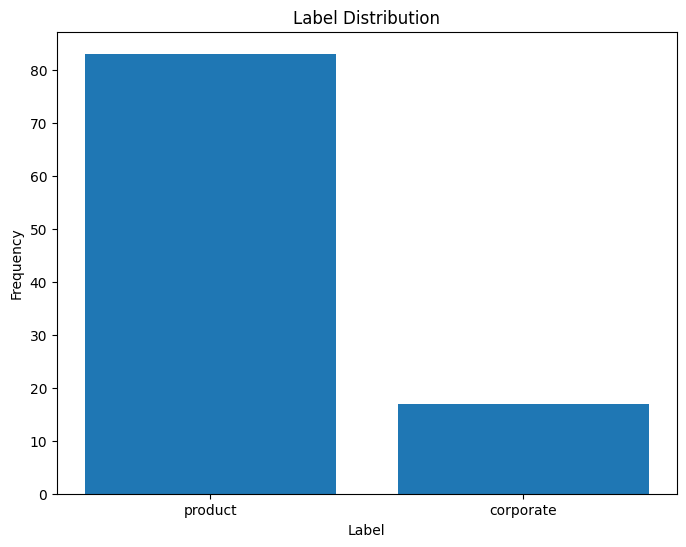

In [4]:
import matplotlib.pyplot as plt
label_counts = one_hundred_labeled_questions['Label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Label Distribution")
plt.show()


In [5]:
five_hundred_labeled_questions = pd.read_csv('Expanded_Labeled_Questions_Dataset.csv')
five_hundred_labeled_questions.head()

,Question,Label
0,What corporate-level changes were discussed in...,corporate
1,How does TI reports financial results for 4Q12...,corporate
2,How does TI's new Ethernet PHYs simplify desig...,product
3,Can you describe the new product TI introduces...,product
4,What corporate-level changes were discussed in...,corporate


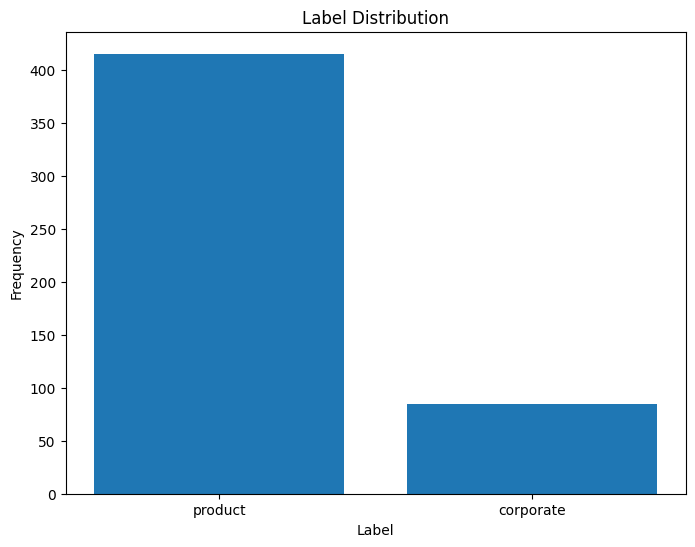

In [6]:
label_counts = five_hundred_labeled_questions['Label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Label Distribution")
plt.show()

# Analysis

I built a dataset of 100 labeled questions and trained a BertforSequence classification neural network. However, training and validation loss were too large. This led me to expand the dataset to 500 labeled questions by leveraging newsroom headlines as the basis for their expansion.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import os
os.environ["WANDB_DISABLED"] = "true"

df = pd.read_csv('Generated_Labeled_Questions.csv')

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
num_classes = len(label_encoder.classes_)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Question'], df['Label'], test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class QuestionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = QuestionDataset(train_texts, train_labels, tokenizer)
test_dataset = QuestionDataset(test_texts, test_labels, tokenizer)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_classes
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

trainer.evaluate()

model.save_pretrained("bert_multiclass_model")
tokenizer.save_pretrained("bert_multiclass_model")

def predict_question(question, model, tokenizer):
    encoding = tokenizer(
        question,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

#Example Usage
example_question = "What are the features of the new product?"
predicted_label = predict_question(example_question, model, tokenizer)
print(f"Predicted Label: {predicted_label}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-2-11a9406a745a>:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.681760
2,0.628900,0.666416
3,0.628900,0.645668


Predicted Label: product


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import os
os.environ["WANDB_DISABLED"] = "true"

df = pd.read_csv('Expanded_Labeled_Questions_Dataset.csv')

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
num_classes = len(label_encoder.classes_)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Question'], df['Label'], test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class QuestionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = QuestionDataset(train_texts, train_labels, tokenizer)
test_dataset = QuestionDataset(test_texts, test_labels, tokenizer)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_classes
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

trainer.evaluate()

model.save_pretrained("bert_multiclass_model")
tokenizer.save_pretrained("bert_multiclass_model")

def predict_question(question, model, tokenizer):
    encoding = tokenizer(
        question,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

#Example Usage
example_question = "What are the features of the new FET?"
predicted_label = predict_question(example_question, model, tokenizer)
print(f"Predicted Label: {predicted_label}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-428ae0d6e4c7>:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.457300,0.438797


Epoch,Training Loss,Validation Loss
1,0.457300,0.438797
2,0.350400,0.278987
3,0.175500,0.104497


Predicted Label: product


Saved the model to avoid the need to train again

In [6]:
model.save_pretrained("bert_vqbc_model")
tokenizer.save_pretrained("bert_vqbc_model")

('bert_vqbc_model/tokenizer_config.json',
 'bert_vqbc_model/special_tokens_map.json',
 'bert_vqbc_model/vocab.txt',
 'bert_vqbc_model/added_tokens.json')

In [7]:
!zip -r bert_vqbc_model.zip bert_vqbc_model

  adding: bert_vqbc_model/ (stored 0%)
  adding: bert_vqbc_model/vocab.txt (deflated 53%)
  adding: bert_vqbc_model/config.json (deflated 49%)
  adding: bert_vqbc_model/model.safetensors (deflated 7%)
  adding: bert_vqbc_model/tokenizer_config.json (deflated 75%)
  adding: bert_vqbc_model/special_tokens_map.json (deflated 42%)


In [9]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert_vqbc_model")
model = BertForSequenceClassification.from_pretrained("bert_vqbc_model")

model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
from torch.utils.data import DataLoader
from torch.nn.functional import softmax

def tokenize_function(texts, labels, tokenizer, max_len=128):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors="pt",
    )
    encodings["labels"] = torch.tensor(labels.tolist())
    return encodings

val_encodings = tokenize_function(test_texts, test_labels, tokenizer)
val_dataset = torch.utils.data.TensorDataset(
    val_encodings["input_ids"],
    val_encodings["attention_mask"],
    val_encodings["labels"]
)

val_loader = DataLoader(val_dataset, batch_size=16)


# Results

In [12]:
from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

#Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 100.00%


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

from torch.nn.functional import softmax
probs = []
for batch in val_loader:
    input_ids, attention_mask, labels = batch
    outputs = model(input_ids, attention_mask=attention_mask)
    probs.extend(softmax(outputs.logits, dim=1)[:, 1].tolist())
auc_roc = roc_auc_score(all_labels, probs)

conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc_roc:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00
Confusion Matrix:
[[17  0]
 [ 0 83]]


# Conclusion

Based on the results and the validation loss, this model proved to be suitable for navigating a split vector database. The reason for the split database that leverages a classifier rather than running in parallel is that newsroom data is usually one aspect of a corporate RAG system and multiple cosine similarity searches already run in parallel with it.